In [195]:
import requests
import time
import re
from bs4 import BeautifulSoup

In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

# Building out a lexicon for news sentiment analysis
#### Data from (https://sraf.nd.edu/textual-analysis/resources/#LM%20Sentiment%20Word%20Lists)

In [8]:
xls = pd.ExcelFile("data/loughran_sentiment_dictionary.xlsx")

In [9]:
pos = pd.read_excel(xls, "Positive")
positive_words = list(pos["ABLE"])
print(positive_words[:10])
print(len(positive_words))

['ABUNDANCE', 'ABUNDANT', 'ACCLAIMED', 'ACCOMPLISH', 'ACCOMPLISHED', 'ACCOMPLISHES', 'ACCOMPLISHING', 'ACCOMPLISHMENT', 'ACCOMPLISHMENTS', 'ACHIEVE']
353


In [10]:
neg = pd.read_excel(xls, "Negative")
negative_words = list(neg["ABANDON"])
print(negative_words[:10])
print(len(negative_words))

['ABANDONED', 'ABANDONING', 'ABANDONMENT', 'ABANDONMENTS', 'ABANDONS', 'ABDICATED', 'ABDICATES', 'ABDICATING', 'ABDICATION', 'ABDICATIONS']
2354


Data also contains strong/weak modals and uncertain words.. not going to use for now, but could look into this later

In [11]:
unc = pd.read_excel(xls, "Uncertainty")
strong = pd.read_excel(xls, "StrongModal")
weak = pd.read_excel(xls, "WeakModal")
print(unc.size, strong.size, weak.size)

296 18 26


#### Following data taken from (http://mpqa.cs.pitt.edu/lexicons/subj_lexicon/)
Going to supplement the above words with this "subjective" lexicon.

In [12]:
subj = pd.read_csv("data/subj-clues.csv")
# Drop extra values
subj.drop(inplace=True, columns=["Unnamed: 0", "Unnamed: 2", "Unnamed: 3",	"Unnamed: 4", "Unnamed: 5",	"Unnamed: 6"])
subj.rename(inplace=True, index=str, columns={"values": "subj"})
print(subj.shape)

(8222, 1)


In [13]:
# Functions to parse the values for word and sentiment polarity
def word(x):
    return x.split(" ")[2].split("=")[1]
def sent(x):
    if len(x.split(" ")) > 5:
        if len(x.split(" ")[5].split("=")) > 1:
            return x.split(" ")[5].split("=")[1]
        else:
            return "NaN"
    else:
        return "NaN"
    
# Transform dataframe to only have word and associated polarity
word_vect = np.vectorize(word)
sent_vect = np.vectorize(sent)
subj = subj.assign(word=lambda x: word_vect(x.subj))
subj = subj.assign(sent=lambda x: sent_vect(x.subj))
subj.drop(columns=["subj"], inplace=True)
subj.shape

(8222, 2)

In [14]:
subj.astype(bool).sum(axis=0)

word    8222
sent    8222
dtype: int64

In [15]:
subj.head()

,word,sent
0,abandoned,negative
1,abandonment,negative
2,abandon,negative
3,abase,negative
4,abasement,negative


In [16]:
subj[subj['sent'].str.contains('negative', regex=False)].shape

(4911, 2)

In [17]:
subj[subj['sent'].str.contains('positive', regex=False)].shape

(2718, 2)

In [18]:
subj[~(subj['sent'].str.contains('positive', regex=False) | subj['sent'].str.contains('negative', regex=False))].shape

(593, 2)

In [19]:
subj.shape

(8222, 2)

Now, adding these new words to our list of positive/negative words

In [151]:
positive_words += list(subj[subj['sent'].str.contains('positive', regex=False)]['word'])
negative_words += list(subj[subj['sent'].str.contains('negative', regex=False)]['word'])
print(len(positive_words))
print(len(negative_words))

3071
7265


Removing duplicates

In [152]:
print(len(set(positive_words)))
print(len(set(negative_words)))
positive_words = list(set(positive_words))
negative_words = list(set(negative_words))

2485
5763


In [153]:
# Turn all words to lower case
positive_words = [x.lower() for x in positive_words]
negative_words = [x.lower() for x in negative_words]
# Take top 2500 from each set of words, to even odds between pos/neg
pos_words = positive_words[:2500]
neg_words = negative_words[:2500]

In [150]:
print(pos_words[:20])
print(neg_words[:20])

['improved', 'collaborations', 'assure', 'smooths', 'bolsters', 'accomplishment', 'excellent', 'dream', 'solves', 'best', 'outperformed', 'enjoyment', 'advances', 'easier', 'progresses', 'opportunities', 'informative', 'prosperous', 'regained', 'inventors']
['disgraceful', 'defame', 'abrogated', 'untruth', 'misrepresented', 'unprofitable', 'overproduced', 'dissatisfaction', 'demoting', 'disruptive', 'contraction', 'sharply', 'evicts', 'unreliable', 'protesters', 'slowed', 'interrupting', 'bankrupts', 'misprice', 'cyberattack']


The words seem to make sense...

# Validation
I am simply checking whether how many good/bad words are contained in the test files.

Using a simple rule-based algorithm - count of positive words vs negative words (the resulting sentiment for now will simply be positive - negative word counts).

In [187]:
# Test files
fb = "fb-bad.txt"
fb2 = "fb-sure-bad.txt"
goog = "goog-bad.txt"
pix = "pixel-bad.txt"
uber = "uber-bad.txt"
test = "test/"
file = test + uber

def get_rule_sentiment(text):
    """ Given a string, return number of (pos, neg) words. """
    # Use regex to split text into list of words
    words = re.sub("[^\w]", " ",  text).split()
    # Get number of pos/neg words
    pos = len([c for c in words if c.lower() in pos_words])
    neg = len([c for c in words if c.lower() in neg_words])
#     print("Number of positive words:", pos)    
#     print("Number of negative words:", neg)
    return (pos - neg)
    
with open(file) as f:
    data = f.read()
    print(words[:100])
    display(get_rule_sentiment(data))

['Uber', 's', 'Stock', 'Disappoints', 'Capping', 'a', 'Rocky', 'Path', 'to', 'Its', 'I', 'P', 'O', 'Uber', 'is', 'the', 'biggest', 'company', 'to', 'emerge', 'from', 'an', 'age', 'of', 'smartphone', 'apps', 'but', 'its', 'road', 'to', 'the', 'public', 'market', 'has', 'been', 'rocky', 'Credit', 'Jeenah', 'Moon', 'for', 'The', 'New', 'York', 'Times', 'Image', 'Uber', 'is', 'the', 'biggest', 'company', 'to', 'emerge', 'from', 'an', 'age', 'of', 'smartphone', 'apps', 'but', 'its', 'road', 'to', 'the', 'public', 'market', 'has', 'been', 'rocky', 'CreditCreditJeenah', 'Moon', 'for', 'The', 'New', 'York', 'Times', 'By', 'Mike', 'Isaac', 'May', '10', '2019', '302', 'Over', 'the', 'past', 'decade', 'Uber', 'changed', 'urban', 'transportation', 'disrupted', 'entrenched', 'taxi', 'industries', 'defied', 'regulators', 'the', 'world', 'over', 'and']


18

Going to try to get time-series data for news articles using NYT's API for Google.

Note: NYT Article Search API only allows for 10 results at once, so must use pagination.

In [91]:
api_key = "AoA9eRNg2H99U2r61TbmsEoiWxVABIjD"
query = "Google"

Response.meta.hits gives us the number of pages of results.

In [96]:
# Store all doc/publish dates as list of tuples
docs = []
# First query to get number of hits
resp = requests.get(
    'https://api.nytimes.com/svc/search/v2/articlesearch.json',
    params={
        'q': query,
        'api-key' : api_key},
)
rj = resp.json()
hits = rj['response']['meta']['hits']
print("Number of pages:", hits)
docs.extend([(x['web_url'], x['pub_date']) for x in rj["response"]["docs"]])

c = 1
# Just going up to 100 requests for now
while c <= min(hits, 100):
    resp = requests.get(
    'https://api.nytimes.com/svc/search/v2/articlesearch.json',
    params={
        'q': query,
        'api-key' : api_key,
        'page' : c
        },
    )
    docs.extend([(x['web_url'], x['pub_date']) for x in rj["response"]["docs"]])
    print("Request #", c, ":", [(x['web_url'], x['pub_date']) for x in rj["response"]["docs"]][:2])
    c += 1
    # Sleep between requests to avoid hitting limit
    time.sleep(6)

Number of pages: 39040
Request 1 [('https://www.nytimes.com/2019/05/07/opinion/google-sundar-pichai-privacy.html', '2019-05-08T00:00:05+0000'), ('https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html', '2019-04-05T17:30:05+0000'), ('https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html', '2019-04-13T14:46:09+0000')]
Request 2 [('https://www.nytimes.com/2019/05/07/opinion/google-sundar-pichai-privacy.html', '2019-05-08T00:00:05+0000'), ('https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html', '2019-04-05T17:30:05+0000'), ('https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html', '2019-04-13T14:46:09+0000')]
Request 3 [('https://www.nytimes.com/2019/05/07/opinion/google-sundar-pichai-privacy.html', '2019-05-08T00:00:05+0000'), ('https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html', '2019-04-05T17:30:05+0000'), ('https://www.nytimes.com/interactive/2019/04/13/us/google-loc

Request 25 [('https://www.nytimes.com/2019/05/07/opinion/google-sundar-pichai-privacy.html', '2019-05-08T00:00:05+0000'), ('https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html', '2019-04-05T17:30:05+0000'), ('https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html', '2019-04-13T14:46:09+0000')]
Request 26 [('https://www.nytimes.com/2019/05/07/opinion/google-sundar-pichai-privacy.html', '2019-05-08T00:00:05+0000'), ('https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html', '2019-04-05T17:30:05+0000'), ('https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html', '2019-04-13T14:46:09+0000')]
Request 27 [('https://www.nytimes.com/2019/05/07/opinion/google-sundar-pichai-privacy.html', '2019-05-08T00:00:05+0000'), ('https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html', '2019-04-05T17:30:05+0000'), ('https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-polic

Request 49 [('https://www.nytimes.com/2019/05/07/opinion/google-sundar-pichai-privacy.html', '2019-05-08T00:00:05+0000'), ('https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html', '2019-04-05T17:30:05+0000'), ('https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html', '2019-04-13T14:46:09+0000')]
Request 50 [('https://www.nytimes.com/2019/05/07/opinion/google-sundar-pichai-privacy.html', '2019-05-08T00:00:05+0000'), ('https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html', '2019-04-05T17:30:05+0000'), ('https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html', '2019-04-13T14:46:09+0000')]
Request 51 [('https://www.nytimes.com/2019/05/07/opinion/google-sundar-pichai-privacy.html', '2019-05-08T00:00:05+0000'), ('https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html', '2019-04-05T17:30:05+0000'), ('https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-polic

Request 73 [('https://www.nytimes.com/2019/05/07/opinion/google-sundar-pichai-privacy.html', '2019-05-08T00:00:05+0000'), ('https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html', '2019-04-05T17:30:05+0000'), ('https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html', '2019-04-13T14:46:09+0000')]
Request 74 [('https://www.nytimes.com/2019/05/07/opinion/google-sundar-pichai-privacy.html', '2019-05-08T00:00:05+0000'), ('https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html', '2019-04-05T17:30:05+0000'), ('https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html', '2019-04-13T14:46:09+0000')]
Request 75 [('https://www.nytimes.com/2019/05/07/opinion/google-sundar-pichai-privacy.html', '2019-05-08T00:00:05+0000'), ('https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html', '2019-04-05T17:30:05+0000'), ('https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-polic

Request 97 [('https://www.nytimes.com/2019/05/07/opinion/google-sundar-pichai-privacy.html', '2019-05-08T00:00:05+0000'), ('https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html', '2019-04-05T17:30:05+0000'), ('https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html', '2019-04-13T14:46:09+0000')]
Request 98 [('https://www.nytimes.com/2019/05/07/opinion/google-sundar-pichai-privacy.html', '2019-05-08T00:00:05+0000'), ('https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html', '2019-04-05T17:30:05+0000'), ('https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html', '2019-04-13T14:46:09+0000')]
Request 99 [('https://www.nytimes.com/2019/05/07/opinion/google-sundar-pichai-privacy.html', '2019-05-08T00:00:05+0000'), ('https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html', '2019-04-05T17:30:05+0000'), ('https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-polic

This is some script I wrote previously that uses BeautifulSoup to get an NYT article given its url:

In [73]:
def get_nyt_article(url):
    r = requests.get(url, allow_redirects=True)
    if r.status_code >= 500:
        print("Server error! Status code:", r.status_code, "Returning...")
        return None, None, None, None
    if r.status_code >= 400 and r.status_code < 500:
        print("Bad request! Status code:", r.status_code, "Returning...")
        return None, None, None, None
    soup = BeautifulSoup(r.content, "html.parser")
    title = soup.title.get_text()
    paragraphs = "" 
    para = soup.findAll("p", {"class":"css-1ygdjhk evys1bk0"})
    for p in para:
        paragraphs += p.get_text()
    return title, url, paragraphs

Let's now construct a dataframe with sentiment for all documents.

In [208]:
data = []
i = 0
count = 0
for d in docs:
    print("Processing doc #", i, "-", d[0])
    i += 1
    sent = get_rule_sentiment(get_nyt_article(d[0])[2])
    if (sent == 0):
        count += 1
#         print("WE GOT A ZERO HERE : ", count, i)
    data.append([d[0], d[1], sent])
print("Number of zeros: ", count)

Processing doc # 0 - https://www.nytimes.com/2019/05/07/opinion/google-sundar-pichai-privacy.html
Processing doc # 1 - https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html
Processing doc # 2 - https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html
Processing doc # 3 - https://www.nytimes.com/2019/05/14/technology/google-shopping-amazon-rivalry.html
Processing doc # 4 - https://www.nytimes.com/2019/04/13/technology/google-sensorvault-location-tracking.html
Processing doc # 5 - https://www.nytimes.com/2019/05/10/technology/facebook-google-privacy.html
Processing doc # 6 - https://www.nytimes.com/2019/04/22/technology/google-walkout-employees-retaliation.html
Processing doc # 7 - https://www.nytimes.com/2019/05/07/technology/google-privacy-tools.html
Processing doc # 8 - https://www.nytimes.com/2019/03/19/technology/google-stadia-video-game-streaming.html
Processing doc # 9 - https://www.nytimes.com/2019/02/21/technology/google-forced-arbi

Processing doc # 81 - https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html
Processing doc # 82 - https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html
Processing doc # 83 - https://www.nytimes.com/2019/05/14/technology/google-shopping-amazon-rivalry.html
Processing doc # 84 - https://www.nytimes.com/2019/04/13/technology/google-sensorvault-location-tracking.html
Processing doc # 85 - https://www.nytimes.com/2019/05/10/technology/facebook-google-privacy.html
Processing doc # 86 - https://www.nytimes.com/2019/04/22/technology/google-walkout-employees-retaliation.html
Processing doc # 87 - https://www.nytimes.com/2019/05/07/technology/google-privacy-tools.html
Processing doc # 88 - https://www.nytimes.com/2019/03/19/technology/google-stadia-video-game-streaming.html
Processing doc # 89 - https://www.nytimes.com/2019/02/21/technology/google-forced-arbitration.html
Processing doc # 90 - https://www.nytimes.com/2019/05/07/opinion/google-sund

Processing doc # 161 - https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html
Processing doc # 162 - https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html
Processing doc # 163 - https://www.nytimes.com/2019/05/14/technology/google-shopping-amazon-rivalry.html
Processing doc # 164 - https://www.nytimes.com/2019/04/13/technology/google-sensorvault-location-tracking.html
Processing doc # 165 - https://www.nytimes.com/2019/05/10/technology/facebook-google-privacy.html
Processing doc # 166 - https://www.nytimes.com/2019/04/22/technology/google-walkout-employees-retaliation.html
Processing doc # 167 - https://www.nytimes.com/2019/05/07/technology/google-privacy-tools.html
Processing doc # 168 - https://www.nytimes.com/2019/03/19/technology/google-stadia-video-game-streaming.html
Processing doc # 169 - https://www.nytimes.com/2019/02/21/technology/google-forced-arbitration.html
Processing doc # 170 - https://www.nytimes.com/2019/05/07/opinion/g

Processing doc # 241 - https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html
Processing doc # 242 - https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html
Processing doc # 243 - https://www.nytimes.com/2019/05/14/technology/google-shopping-amazon-rivalry.html
Processing doc # 244 - https://www.nytimes.com/2019/04/13/technology/google-sensorvault-location-tracking.html
Processing doc # 245 - https://www.nytimes.com/2019/05/10/technology/facebook-google-privacy.html
Processing doc # 246 - https://www.nytimes.com/2019/04/22/technology/google-walkout-employees-retaliation.html
Processing doc # 247 - https://www.nytimes.com/2019/05/07/technology/google-privacy-tools.html
Processing doc # 248 - https://www.nytimes.com/2019/03/19/technology/google-stadia-video-game-streaming.html
Processing doc # 249 - https://www.nytimes.com/2019/02/21/technology/google-forced-arbitration.html
Processing doc # 250 - https://www.nytimes.com/2019/05/07/opinion/g

Processing doc # 321 - https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html
Processing doc # 322 - https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html
Processing doc # 323 - https://www.nytimes.com/2019/05/14/technology/google-shopping-amazon-rivalry.html
Processing doc # 324 - https://www.nytimes.com/2019/04/13/technology/google-sensorvault-location-tracking.html
Processing doc # 325 - https://www.nytimes.com/2019/05/10/technology/facebook-google-privacy.html
Processing doc # 326 - https://www.nytimes.com/2019/04/22/technology/google-walkout-employees-retaliation.html
Processing doc # 327 - https://www.nytimes.com/2019/05/07/technology/google-privacy-tools.html
Processing doc # 328 - https://www.nytimes.com/2019/03/19/technology/google-stadia-video-game-streaming.html
Processing doc # 329 - https://www.nytimes.com/2019/02/21/technology/google-forced-arbitration.html
Processing doc # 330 - https://www.nytimes.com/2019/05/07/opinion/g

Processing doc # 401 - https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html
Processing doc # 402 - https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html
Processing doc # 403 - https://www.nytimes.com/2019/05/14/technology/google-shopping-amazon-rivalry.html
Processing doc # 404 - https://www.nytimes.com/2019/04/13/technology/google-sensorvault-location-tracking.html
Processing doc # 405 - https://www.nytimes.com/2019/05/10/technology/facebook-google-privacy.html
Processing doc # 406 - https://www.nytimes.com/2019/04/22/technology/google-walkout-employees-retaliation.html
Processing doc # 407 - https://www.nytimes.com/2019/05/07/technology/google-privacy-tools.html
Processing doc # 408 - https://www.nytimes.com/2019/03/19/technology/google-stadia-video-game-streaming.html
Processing doc # 409 - https://www.nytimes.com/2019/02/21/technology/google-forced-arbitration.html
Processing doc # 410 - https://www.nytimes.com/2019/05/07/opinion/g

Processing doc # 481 - https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html
Processing doc # 482 - https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html
Processing doc # 483 - https://www.nytimes.com/2019/05/14/technology/google-shopping-amazon-rivalry.html
Processing doc # 484 - https://www.nytimes.com/2019/04/13/technology/google-sensorvault-location-tracking.html
Processing doc # 485 - https://www.nytimes.com/2019/05/10/technology/facebook-google-privacy.html
Processing doc # 486 - https://www.nytimes.com/2019/04/22/technology/google-walkout-employees-retaliation.html
Processing doc # 487 - https://www.nytimes.com/2019/05/07/technology/google-privacy-tools.html
Processing doc # 488 - https://www.nytimes.com/2019/03/19/technology/google-stadia-video-game-streaming.html
Processing doc # 489 - https://www.nytimes.com/2019/02/21/technology/google-forced-arbitration.html
Processing doc # 490 - https://www.nytimes.com/2019/05/07/opinion/g

Processing doc # 561 - https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html
Processing doc # 562 - https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html
Processing doc # 563 - https://www.nytimes.com/2019/05/14/technology/google-shopping-amazon-rivalry.html
Processing doc # 564 - https://www.nytimes.com/2019/04/13/technology/google-sensorvault-location-tracking.html
Processing doc # 565 - https://www.nytimes.com/2019/05/10/technology/facebook-google-privacy.html
Processing doc # 566 - https://www.nytimes.com/2019/04/22/technology/google-walkout-employees-retaliation.html
Processing doc # 567 - https://www.nytimes.com/2019/05/07/technology/google-privacy-tools.html
Processing doc # 568 - https://www.nytimes.com/2019/03/19/technology/google-stadia-video-game-streaming.html
Processing doc # 569 - https://www.nytimes.com/2019/02/21/technology/google-forced-arbitration.html
Processing doc # 570 - https://www.nytimes.com/2019/05/07/opinion/g

Processing doc # 641 - https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html
Processing doc # 642 - https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html
Processing doc # 643 - https://www.nytimes.com/2019/05/14/technology/google-shopping-amazon-rivalry.html
Processing doc # 644 - https://www.nytimes.com/2019/04/13/technology/google-sensorvault-location-tracking.html
Processing doc # 645 - https://www.nytimes.com/2019/05/10/technology/facebook-google-privacy.html
Processing doc # 646 - https://www.nytimes.com/2019/04/22/technology/google-walkout-employees-retaliation.html
Processing doc # 647 - https://www.nytimes.com/2019/05/07/technology/google-privacy-tools.html
Processing doc # 648 - https://www.nytimes.com/2019/03/19/technology/google-stadia-video-game-streaming.html
Processing doc # 649 - https://www.nytimes.com/2019/02/21/technology/google-forced-arbitration.html
Processing doc # 650 - https://www.nytimes.com/2019/05/07/opinion/g

Processing doc # 721 - https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html
Processing doc # 722 - https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html
Processing doc # 723 - https://www.nytimes.com/2019/05/14/technology/google-shopping-amazon-rivalry.html
Processing doc # 724 - https://www.nytimes.com/2019/04/13/technology/google-sensorvault-location-tracking.html
Processing doc # 725 - https://www.nytimes.com/2019/05/10/technology/facebook-google-privacy.html
Processing doc # 726 - https://www.nytimes.com/2019/04/22/technology/google-walkout-employees-retaliation.html
Processing doc # 727 - https://www.nytimes.com/2019/05/07/technology/google-privacy-tools.html
Processing doc # 728 - https://www.nytimes.com/2019/03/19/technology/google-stadia-video-game-streaming.html
Processing doc # 729 - https://www.nytimes.com/2019/02/21/technology/google-forced-arbitration.html
Processing doc # 730 - https://www.nytimes.com/2019/05/07/opinion/g

Processing doc # 801 - https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html
Processing doc # 802 - https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html
Processing doc # 803 - https://www.nytimes.com/2019/05/14/technology/google-shopping-amazon-rivalry.html
Processing doc # 804 - https://www.nytimes.com/2019/04/13/technology/google-sensorvault-location-tracking.html
Processing doc # 805 - https://www.nytimes.com/2019/05/10/technology/facebook-google-privacy.html
Processing doc # 806 - https://www.nytimes.com/2019/04/22/technology/google-walkout-employees-retaliation.html
Processing doc # 807 - https://www.nytimes.com/2019/05/07/technology/google-privacy-tools.html
Processing doc # 808 - https://www.nytimes.com/2019/03/19/technology/google-stadia-video-game-streaming.html
Processing doc # 809 - https://www.nytimes.com/2019/02/21/technology/google-forced-arbitration.html
Processing doc # 810 - https://www.nytimes.com/2019/05/07/opinion/g

Processing doc # 881 - https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html
Processing doc # 882 - https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html
Processing doc # 883 - https://www.nytimes.com/2019/05/14/technology/google-shopping-amazon-rivalry.html
Processing doc # 884 - https://www.nytimes.com/2019/04/13/technology/google-sensorvault-location-tracking.html
Processing doc # 885 - https://www.nytimes.com/2019/05/10/technology/facebook-google-privacy.html
Processing doc # 886 - https://www.nytimes.com/2019/04/22/technology/google-walkout-employees-retaliation.html
Processing doc # 887 - https://www.nytimes.com/2019/05/07/technology/google-privacy-tools.html
Processing doc # 888 - https://www.nytimes.com/2019/03/19/technology/google-stadia-video-game-streaming.html
Processing doc # 889 - https://www.nytimes.com/2019/02/21/technology/google-forced-arbitration.html
Processing doc # 890 - https://www.nytimes.com/2019/05/07/opinion/g

Processing doc # 961 - https://www.nytimes.com/2019/04/05/opinion/letters/therapy-google.html
Processing doc # 962 - https://www.nytimes.com/interactive/2019/04/13/us/google-location-tracking-police.html
Processing doc # 963 - https://www.nytimes.com/2019/05/14/technology/google-shopping-amazon-rivalry.html
Processing doc # 964 - https://www.nytimes.com/2019/04/13/technology/google-sensorvault-location-tracking.html
Processing doc # 965 - https://www.nytimes.com/2019/05/10/technology/facebook-google-privacy.html
Processing doc # 966 - https://www.nytimes.com/2019/04/22/technology/google-walkout-employees-retaliation.html
Processing doc # 967 - https://www.nytimes.com/2019/05/07/technology/google-privacy-tools.html
Processing doc # 968 - https://www.nytimes.com/2019/03/19/technology/google-stadia-video-game-streaming.html
Processing doc # 969 - https://www.nytimes.com/2019/02/21/technology/google-forced-arbitration.html
Processing doc # 970 - https://www.nytimes.com/2019/05/07/opinion/g

In [209]:
df = pd.DataFrame(data, columns = ['url', 'date', 'sentiment'])

In [210]:
display(df.head())
print(df.shape)

,url,date,sentiment
0,https://www.nytimes.com/2019/05/07/opinion/goo...,2019-05-08T00:00:05+0000,92
1,https://www.nytimes.com/2019/04/05/opinion/let...,2019-04-05T17:30:05+0000,9
2,https://www.nytimes.com/interactive/2019/04/13...,2019-04-13T14:46:09+0000,0
3,https://www.nytimes.com/2019/05/14/technology/...,2019-05-14T15:56:07+0000,26
4,https://www.nytimes.com/2019/04/13/technology/...,2019-04-13T14:53:31+0000,15


(1010, 3)


Now, let's try to display the time-series data.

In [211]:
# Convert date from string to datetime
df['date'] = pd.to_datetime(df['date'])
# Set index as date and drop the original column
df.index = df['date']
df.drop(columns=['date'], inplace=True)
df.head()

,url,sentiment
date,,
2019-05-08 00:00:05,https://www.nytimes.com/2019/05/07/opinion/goo...,92
2019-04-05 17:30:05,https://www.nytimes.com/2019/04/05/opinion/let...,9
2019-04-13 14:46:09,https://www.nytimes.com/interactive/2019/04/13...,0
2019-05-14 15:56:07,https://www.nytimes.com/2019/05/14/technology/...,26
2019-04-13 14:53:31,https://www.nytimes.com/2019/04/13/technology/...,15


In [212]:
# Remove NaNs
df.fillna(0, inplace=True)
print("Number of zeros for sentiment:", (df['sentiment'] == 0).sum(0))
df.astype(bool).sum(axis=0)

Number of zeros for sentiment: 101


url          1010
sentiment     909
dtype: int64

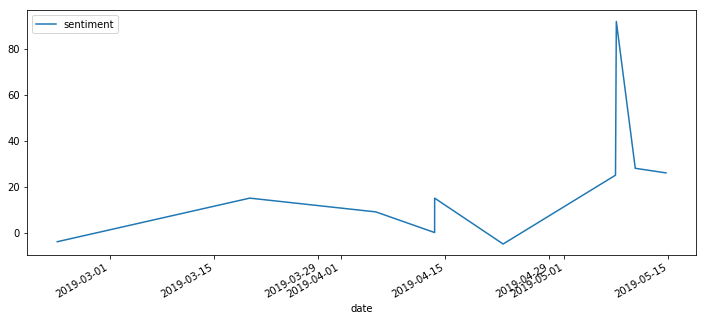

In [229]:
ax = df.plot(figsize=(12,5))

Now, let's get the stock data.

In [215]:
API_URL = "https://www.alphavantage.co/query"
data = {
    "function": "TIME_SERIES_DAILY",
    "datatype": "json",
    "apikey": "94Z49Z19XNL1GGGP",
    }
data['symbol'] = "GOOG"
response = requests.get(API_URL, data)

In [216]:
raw = response.json()["Time Series (Daily)"]
st = pd.DataFrame.from_dict(raw, orient = "index").reset_index(0).rename(columns = {"index": "ds"})
st.head()

,ds,1. open,2. high,3. low,4. close,5. volume
0,2018-12-20,1018.1300,1034.2200,996.3600,1009.4100,2673464
1,2018-12-21,1015.3000,1024.0200,973.6900,979.5400,4595891
2,2018-12-24,973.9000,1003.5400,970.1100,976.2200,1590328
3,2018-12-26,989.0100,1040.0000,983.0000,1039.4600,2373270
4,2018-12-27,1017.1500,1043.8900,997.0000,1043.8800,2109777


In [220]:
st['ds'] = pd.to_datetime(st.ds)
labels = ['1. open', '2. high', '3. low', '4. close', '5. volume']
st[labels] = st[labels].apply(pd.to_numeric)
st.index = st['ds']
st.drop(columns=['ds'], inplace=True)

AttributeError: 'AxesSubplot' object has no attribute 'show'

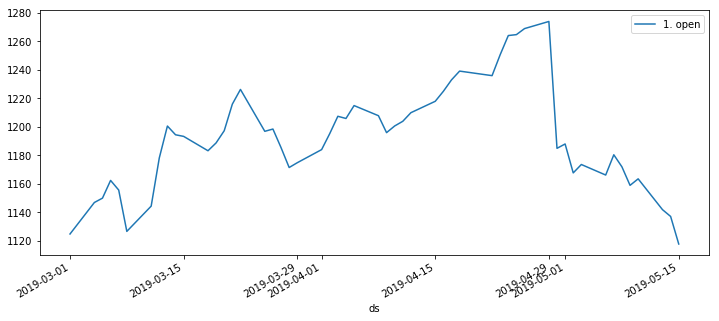

In [242]:
st[datetime(2019, 3, 1):].plot(kind = "line", y = ['1. open'], figsize=(12,5))
plt.show()
df.plot(figsize=(12,5))

In [241]:
st[datetime(2019, 3, 1):].plot(ax = ax, figsize=(12,5))

In [243]:
%reset_selective -f plt